### Importações 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)


# classificador referência
from sklearn.dummy import DummyClassifier

# estudo lineares
from sklearn.linear_model import LogisticRegression

# estudo árvores
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# estudo SVM
from sklearn.svm import SVC

# estudo kNN
from sklearn.neighbors import KNeighborsClassifier

# exportar o modelo
from joblib import dump

from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS, MODELO_FINAL
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_rus import RANDOM_STATE
from src.models_rus import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

### Visualizando a base

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int8  
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int16 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int8  
 6   Education                 1470 non-null   int8  
 7   EducationField            1470 non-null   object
 8   EnvironmentSatisfaction   1470 non-null   int8  
 9   Gender                    1470 non-null   object
 10  HourlyRate                1470 non-null   int8  
 11  JobInvolvement            1470 non-null   int8  
 12  JobLevel                  1470 non-null   int8  
 13  JobRole                   1470 non-null   object
 14  JobSatisfaction         

### Separando as coluans por tipo

In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

colunas_numericas

['Age',
 'DailyRate',
 'DistanceFromHome',
 'HourlyRate',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

### Separando as colunas que receberão transformações: MinMaxScaler, StanderScaler e PowerTransform

In [5]:
colunas_numericas_min_max = [
    "DailyRate",
    "HourlyRate",
    "MonthlyRate",
]

colunas_numericas_std = ["Age",]

colunas_numericas_power_transform = [
    coluna for coluna in colunas_numericas if coluna not in (
        colunas_numericas_min_max + colunas_numericas_std
    )
]

colunas_numericas_power_transform

['DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

### Separando a base em x e y

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
y[:5]

,Attrition
0,Yes
1,No
2,Yes
3,No
4,No


### Aplicando LabelEncoder na coluna target

In [8]:
le = LabelEncoder()

y = le.fit_transform(y.values.ravel())

y[:10]

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [9]:
le.classes_

array(['No', 'Yes'], dtype=object)

### Definindo KFold para separação da base em treino e teste

In [10]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Definindo os preprocessamentos que serão aplicados 

In [11]:
preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas)
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop="first"), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories="auto"), colunas_categoricas_ordenadas),
        ("min_max", MinMaxScaler(), colunas_numericas_min_max),
        ("stdscaler", StandardScaler(), colunas_numericas_std),
        ("power_transformer", PowerTransformer(), colunas_numericas_power_transform),
    ]
)

In [12]:
# scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1]

# scale_pos_weight

### Definindo os Classificadores que serão testados e organizando os resultados para comparação

In [13]:
classificadores = {
    "DummyClassifier":{
        "preprocessor":None,
        "classificador": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression":{
        "preprocessor":preprocessamento,
        "classificador": LogisticRegression(),
    },
    "DecisionTreeClassifier":{
        "preprocessor":preprocessamento_arvore,
        "classificador": DecisionTreeClassifier(),
    },
    "LGBMClassifier":{
        "preprocessor":preprocessamento_arvore,
        "classificador": LGBMClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1,
            ),
    },
    "XGBClassifier":{
        "preprocessor":preprocessamento_arvore,
        "classificador": XGBClassifier(
            random_state=RANDOM_STATE,
            n_jobs=-1,
            ),
    },
        "SVC":{
        "preprocessor":preprocessamento,
        "classificador": SVC(),
    },
    "kNN":{
        "preprocessor":preprocessamento,
        "classificador": KNeighborsClassifier(),
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_classificacao(
        X,y,kf,**classificador
    )
    for nome_modelo, classificador in classificadores.items()
}


df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature nam

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.006278,0.009772,0.489796,0.510671,0.257426,0.168831,0.541667,0.535315,0.174047,0.016049
1,DummyClassifier,0.003915,0.008352,0.510204,0.506098,0.25,0.166667,0.5,0.560213,0.18301,0.012267
2,DummyClassifier,0.003651,0.008099,0.517007,0.4972,0.236559,0.158273,0.468085,0.544319,0.173542,0.01175
3,DummyClassifier,0.003653,0.008091,0.496599,0.493669,0.237113,0.156463,0.489362,0.540787,0.172244,0.011744
4,DummyClassifier,0.003758,0.008151,0.561224,0.523516,0.254335,0.174603,0.468085,0.569127,0.18293,0.011909
5,LogisticRegression,0.048751,0.024134,0.707483,0.724593,0.455696,0.327273,0.75,0.798103,0.548634,0.072885
6,LogisticRegression,0.034703,0.023798,0.768707,0.744411,0.5,0.386364,0.708333,0.825373,0.565305,0.0585
7,LogisticRegression,0.033785,0.023823,0.72449,0.749892,0.477419,0.342593,0.787234,0.846326,0.65278,0.057608
8,LogisticRegression,0.036465,0.024421,0.751701,0.748859,0.48951,0.364583,0.744681,0.834783,0.608646,0.060886
9,LogisticRegression,0.036422,0.023799,0.758503,0.735679,0.481752,0.366667,0.702128,0.776036,0.572919,0.060221


### Filtrando pela média do test_average_precision

In [14]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.004251,0.008493,0.514966,0.506231,0.247087,0.164967,0.49344,0.549952,0.177154,0.012744
DecisionTreeClassifier,0.010967,0.017196,0.666667,0.656382,0.381731,0.272061,0.641223,0.656382,0.233995,0.028163
kNN,0.031357,0.071552,0.730612,0.665559,0.405845,0.31686,0.569592,0.728196,0.355607,0.10291
XGBClassifier,0.067304,0.024879,0.714286,0.700185,0.434119,0.319391,0.679344,0.773475,0.444256,0.092182
LGBMClassifier,0.031998,0.025627,0.72381,0.715876,0.451201,0.33224,0.704255,0.79084,0.482381,0.057625
LogisticRegression,0.038025,0.023995,0.742177,0.740687,0.480876,0.357496,0.738475,0.816124,0.589657,0.06202
SVC,0.036348,0.039371,0.765306,0.747714,0.500218,0.383697,0.72172,0.826207,0.61304,0.075719


- Analisando os resultados o SVC teve a melhor performance em média. 

- Porém seguiremos com o LogisticRegression que obteve o segundo melhor resuldado, pois ele é superior em outros aspcetos como: tempo, Recall e masi facíl interpretação.

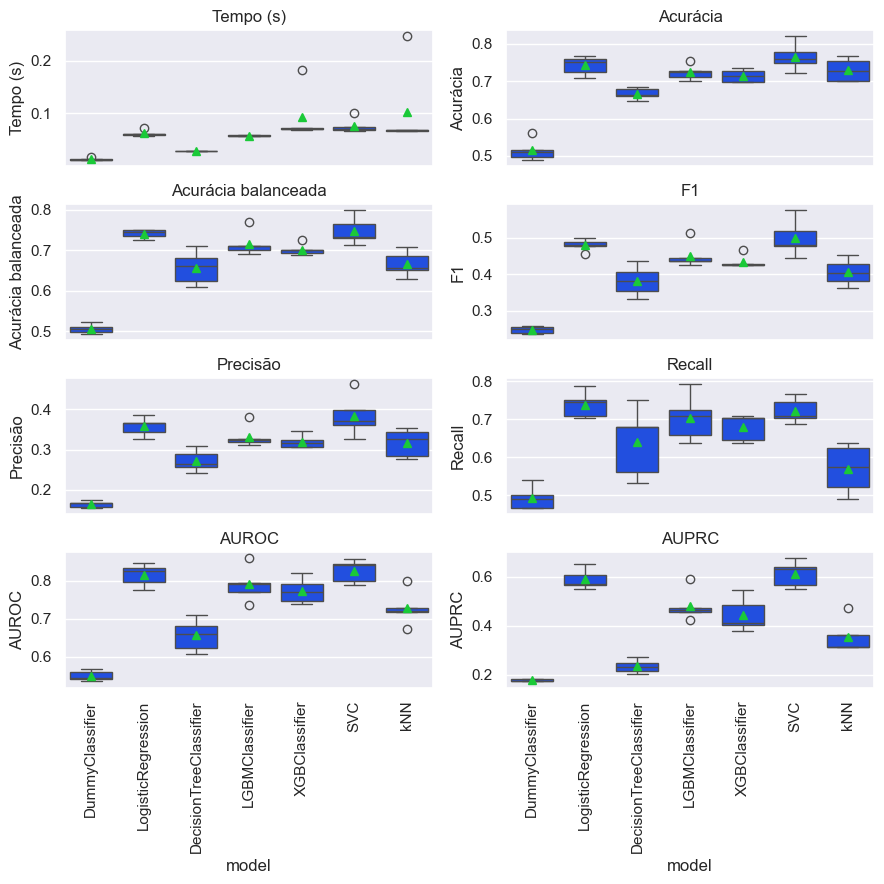

In [15]:
plot_comparar_metricas_modelos(df_resultados=df_resultados)

### Definindo a grade de parametros que ser´pa testada no Logisticregression para obter os melhores parâmetros

In [16]:
param_grid ={
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1","l2","elasticnet", None],
    "clf__l1_ratio": [0.1, 0.25, 0.5, 0.75, 0.9]
}

### Definindo o grid search

In [17]:
clf = LogisticRegression(solver="saga", random_state=RANDOM_STATE)

grid_seach = grid_search_cv_classificador(
    classificador=clf,
    param_grid=param_grid,
    cv=kf,
    preprocessor=preprocessamento,
    refit_metric="average_precision",

)

grid_seach

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

### Treinando o modelo

In [18]:
grid_seach.fit(X,y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


c:\Users\User\anaconda3\envs\machine_learning\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
                                        RandomUnderSampler(random_state=42)),
                                       ('clf',
                                        LogisticRegression(random_state=42,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10, 100],
                         'clf__l1_ratio': [0.1, 0.25, 0.5, 0.75, 0.9],
                         'clf__penalty': ['l1', 'l2', 'elasticnet', None]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

### Melhores parâmetros obtidos

In [19]:
grid_seach.best_params_

{'clf__C': 0.1, 'clf__l1_ratio': 0.1, 'clf__penalty': 'elasticnet'}

### Melhor Score Obtido

In [20]:
grid_seach.best_score_

np.float64(0.6174426856945511)

In [21]:
grid_seach.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_clf__C', 'param_clf__l1_ratio', 'param_clf__penalty', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 'split2_test_recall', 'split3_te

In [22]:
grid_seach.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('sampler', RandomUnderSampler(random_state=42)),
                ('clf',
                 LogisticRegression(C=0.1, l1_ratio=0.1, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

### Verificando o melhor indice 

In [23]:
grid_seach.best_index_

np.int64(2)

### filtrando os resultados pelo indice e pela métrica "mean_test_average_precision"

In [24]:
grid_seach.cv_results_["mean_test_average_precision"][grid_seach.best_index_]

np.float64(0.6174426856945511)

In [25]:
grid_seach.cv_results_["mean_test_accuracy"][grid_seach.best_index_]

np.float64(0.7455782312925171)

### Pegando os nomes dos testes

In [26]:
coluna_test = [coluna for coluna in df_resultados.columns if coluna.startswith("test")]

coluna_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

### pegando os nomes de média dos testes

In [27]:
coluna_test_mean = ["mean_" + coluna for coluna in coluna_test]

coluna_test_mean


['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

### Exibindo todos os resultados de todas as métricas calculadas pelo melhor estimador

In [28]:
for coluna in coluna_test_mean:
    print(f"{coluna}: {grid_seach.cv_results_[coluna][grid_seach.best_index_]:.2%}")

mean_test_accuracy: 74.56%
mean_test_balanced_accuracy: 74.28%
mean_test_f1: 48.37%
mean_test_precision: 36.01%
mean_test_recall: 73.87%
mean_test_roc_auc: 81.96%
mean_test_average_precision: 61.74%


### Verificando os coeficientes

In [29]:
coefs = dataframe_coeficientes(
    grid_seach.best_estimator_["clf"].coef_[0],
    grid_seach.best_estimator_["preprocessor"].get_feature_names_out()
)

coefs

,coeficiente
ordinal__JobInvolvement,-0.495667
power_transformer__MonthlyIncome,-0.389700
one_hot__EducationField_Life Sciences,-0.268742
one_hot__Department_Research & Development,-0.252369
power_transformer__TotalWorkingYears,-0.243814
ordinal__RelationshipSatisfaction,-0.215038
ordinal__StockOptionLevel,-0.204987
power_transformer__YearsWithCurrManager,-0.200748
power_transformer__TrainingTimesLastYear,-0.191032
power_transformer__YearsInCurrentRole,-0.177019


### Verificando os coeficientes que forão zerados, ou seja não são relevantes para o modelo

In [30]:
coefs.query("coeficiente == 0")

,coeficiente
ordinal__PerformanceRating,0.0
one_hot__MaritalStatus_Married,0.0
one_hot__EducationField_Medical,0.0
one_hot__BusinessTravel_Travel_Rarely,0.0
stdscaler__Age,0.0
min_max__MonthlyRate,0.0
min_max__HourlyRate,0.0
one_hot__JobRole_Human Resources,0.0
one_hot__EducationField_Other,0.0


### Exibindo os coeficientes que tem alguma relevância para o modelo

Destaque para OverTime_Yes, que seriam os funcionários que fazem horas extras. Nota-se que essa feature tem uma boa relevância para os resultados.

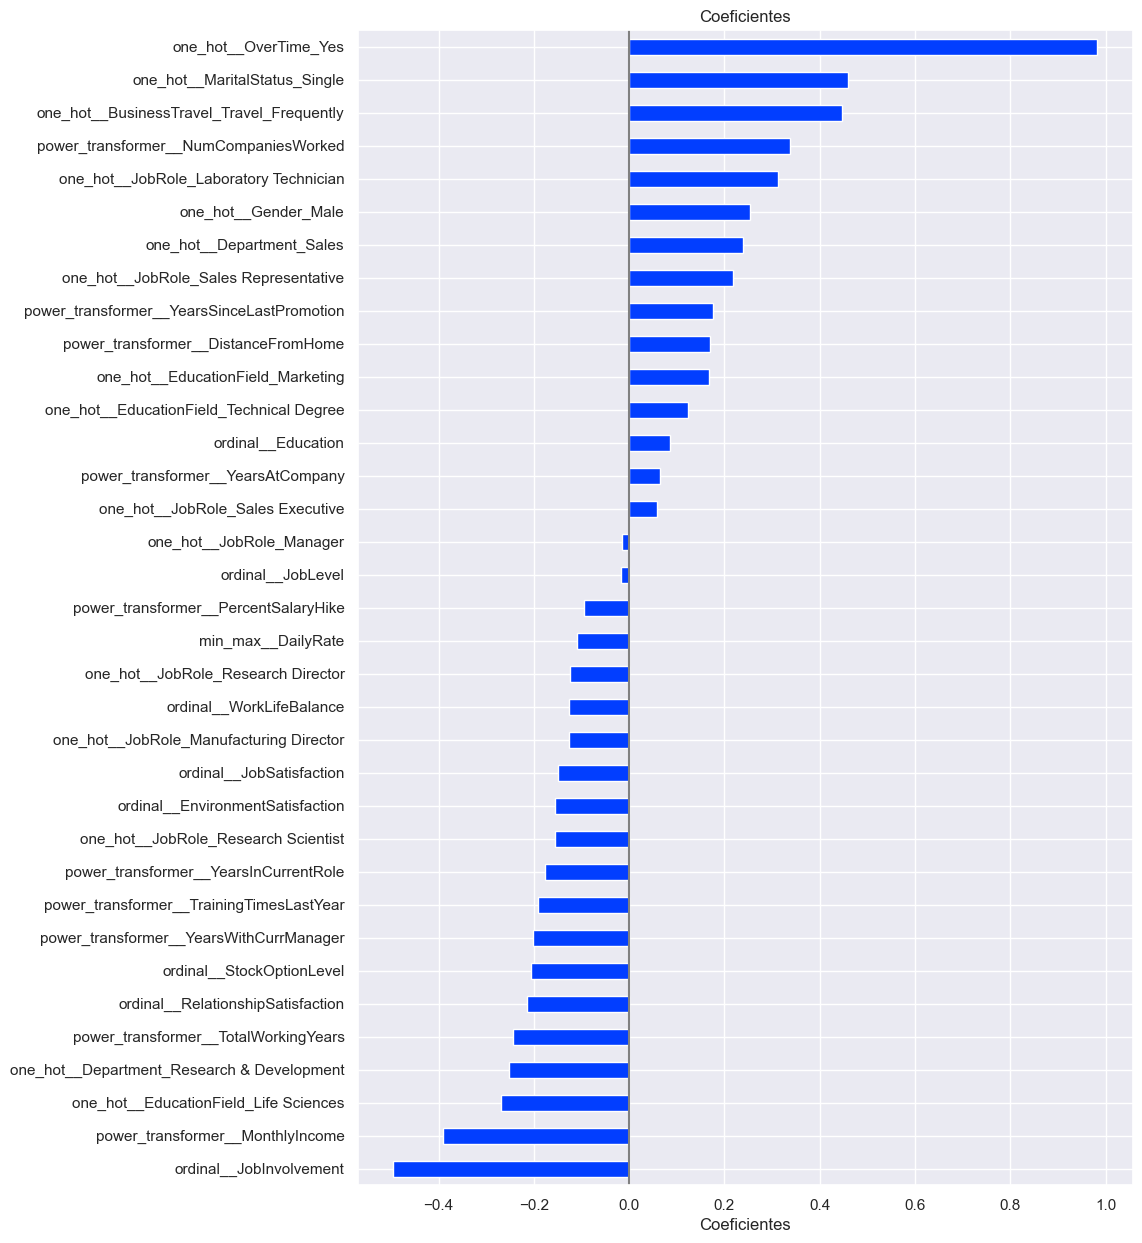

In [31]:
plot_coeficientes(coefs.query("coeficiente !=0"))

In [32]:
coefs_odds = coefs.copy()

coefs_odds["coeficiente"] = np.exp(coefs_odds["coeficiente"])

coefs_odds

,coeficiente
ordinal__JobInvolvement,0.609165
power_transformer__MonthlyIncome,0.677260
one_hot__EducationField_Life Sciences,0.764340
one_hot__Department_Research & Development,0.776958
power_transformer__TotalWorkingYears,0.783633
ordinal__RelationshipSatisfaction,0.806511
ordinal__StockOptionLevel,0.814658
power_transformer__YearsWithCurrManager,0.818119
power_transformer__TrainingTimesLastYear,0.826107
power_transformer__YearsInCurrentRole,0.837764


### Exibindo as ODDS de cada coeficiente

ODDS seriam as chances de ocorrencia.

Neste caso o funcionário que faz horas extras tem pouco mais de 2.5 vezes mais chances de sair da empresa.

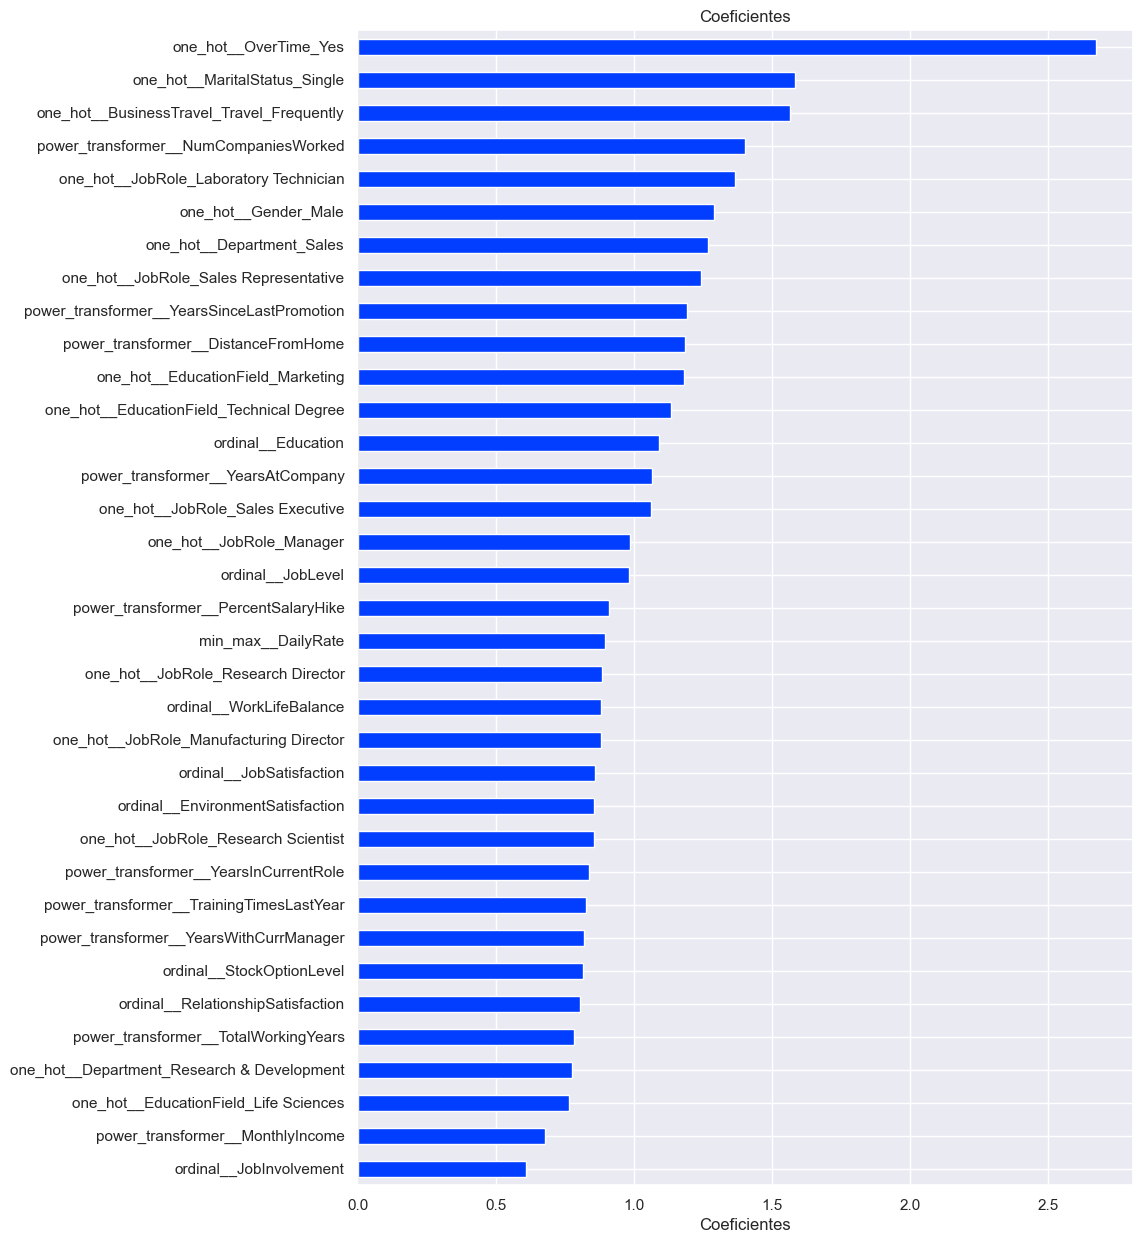

In [33]:
plot_coeficientes(coefs_odds.query("coeficiente !=1"))

### Matriz de Confusão valores Absolutos

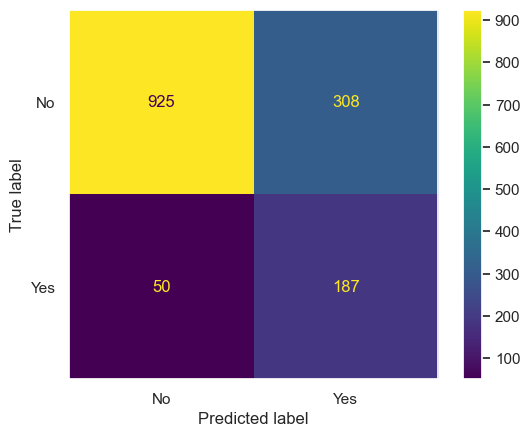

In [34]:
ConfusionMatrixDisplay.from_estimator(
    grid_seach.best_estimator_,
    X,
    y,
    display_labels=le.classes_,

)

plt.grid(False)
plt.show()

### Matriz de Confusão valores Normalizados

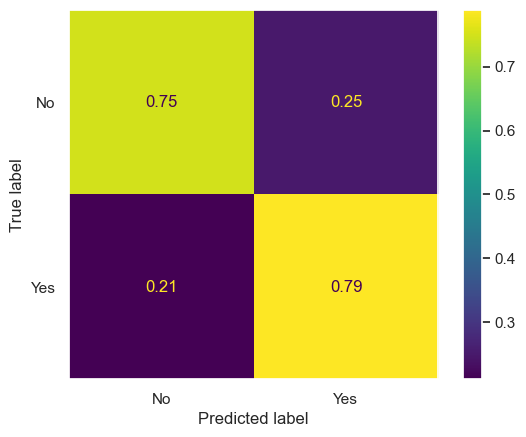

In [35]:
ConfusionMatrixDisplay.from_estimator(
    grid_seach.best_estimator_,
    X,
    y,
    display_labels=le.classes_,
    normalize="true"

)

plt.grid(False)
plt.show()

**Plano de Ação**

- Avaliar os motivos que levam os funcionários a fazerem hora extra.
    - Mão de obra insuficiente
    - Falta de organização institucional
    - Falta de treinamento
    - Necessidade de investimento tecnológico
- Possibilidade de diminuir as viagens de begócios.
    - Como isso afeta a equipe de vendas?
= Como a renda mensal de cada setor e nível da empresa se comprar com o mercado?

Exportando o modelo

In [36]:
dump(grid_seach.best_estimator_, MODELO_FINAL)

['C:\\Users\\User\\Desktop\\GDrive\\Ciência de Dados\\Machine Learning\\Projeto - IBM\\projeto_data_science_IBM\\modelos\\logistic_regression_rus.joblib']